In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Intent classifier

Our intent classifier uses pretrained BERT transformer model. Though it takes a long time to train, the end result is a high accuracy, high speed model.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.8 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 596 kB 63.2 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
import pandas as pd
import re
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam

In [ ]:
class BertClassifier(nn.Module):
      def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        n_classes = len(labels)

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, n_classes)
        self.relu = nn.ReLU()
    

      def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer



We have already finetuned the intent classifier. Here we load the pkl file and put it on the cpu.

In [ ]:
import pickle
intent_classifier = pickle.load(open('drive/MyDrive/COM3029_coursework_2/Main/Components/intent_classifier.pkl', 'rb'))
intent_classifier.to("cpu")

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

For BERT's categorical labels, we supply a dictionary mapping the integer names of the class to the plain text name. Due to BERT not accepting negative values as integer names for the classes, we have to use 15 as the new unknown class number, and account for that later.

In [ ]:
code_names = {
    -1 : "Unknown",
    0 : "Greeting",
    1 : "Name",
    2 : "Address",
    3 : "DeliveryTime",
    4 : "NumberOfPizzas",
    5 : "AddPizza",
    6 : "RemovePizza",
    7 : "EditPizza",
    8 : "AddTopping",
    9 : "RemoveTopping",
    10 : "AddSide",
    11 : "RemoveSide",
    12 : "AddDrink",
    13 : "RemoveDrink",
    14 : "EndConv",
    15 : "Unknown" # for BERT bug that doesn't allow -1
}

BATCH_SIZE = 2

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels =  {v: k for k, v in code_names.items()}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for text in df['input']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Admittedly the get_intent function could be improved in efficiency by figuring out how to use the network to predict single labels instead of converting the input into a length 1 dataset.

In [ ]:
def get_intent(input):
    test_data = pd.DataFrame(zip([input], [0]), columns=['input', 'intent_code'])
    test_data["category"] = test_data["intent_code"].apply(lambda x: code_names[x])
    test = Dataset(test_data)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():

        for test_input, test_label in test_loader:

            #test_label = test_label.to("cuda:0")
            #mask = test_input['attention_mask'].to("cuda:0")
            #input_id = test_input['input_ids'].squeeze(1).to("cuda:0")
            test_label = test_label.to("cpu")
            mask = test_input['attention_mask'].to("cpu")
            input_id = test_input['input_ids'].squeeze(1).to("cpu")
            output = intent_classifier(input_id, mask)
    
    prediction = output.argmax(dim=1).item()

    if prediction == 15:
      prediction = -1

    return prediction

## Stretch Testing the Intent Classifier

An interesting aspect to discuss is how can we ensure the intent classifier knows specific entities are of a certain class, e.g. knowing 12:30 refers to the delivery time class? This is accomplished by first using the NER on the query and then replacing specific instances of an entity with its class, e.g. replacing "12:30" in the user input with "time". 

The dataset for the intent classifier has been updated to ensure that its training data includes examples such as "time" for class 3 (delivery time), and "post code" for class 2 (address). 

With the NER-powered replacement, the intent classifier can correctly understand that a specific postcode refers to the Address class, making the chatbot conversation flow more natural and gives the illusion of it being able to remember context.

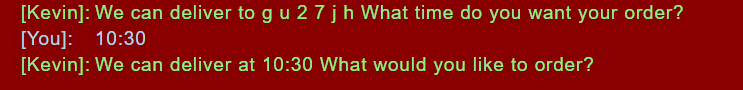

As you can see from above, Pizza Kevin (our chatbot) correctly classed the input of "gu2 7jh" as referring to the address class without even having to explicitly state it is the address. So too with 10:30.

However, there are still some problems. Pizza kevin recognizes any entities that are uppercase as a name. 

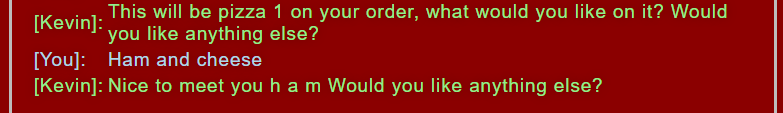

It works when you use all lower case.

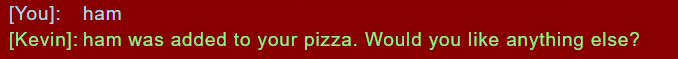

# NER

Our NER component is a 'hybrid' model which consists of two sub-components, each of which is responsible for the detection of a unique set of entity types:
1.   A component which uses a pre-trained transformer (without further fine-tuning) to extract entities of types: name, time, cardinal
2.   A component which uses simple heuristics (no machine learning) to extract entities of types: postcode, topping, side, drink

In prior experimentation pertaining to named entity recognition, the hybrid model used here outperformed (in terms of accuracy) the pre-trained transformer on its own, as well as the simple heuristics model on its own, in detecting entities of all of the defined types.

While the hybrid model takes less time to make predictions than the pre-trained transformer, it is outperformed by heuristics model for this metric, however, the accuracy of the heuristics model on its own is poor compared to the hybrid model. 

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from difflib import get_close_matches
from difflib import SequenceMatcher
from functools import reduce
import re
import random
from random import randint

In [ ]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 8.6 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 181 kB 53.6 MB/s 
     |████████████████████████████████| 457 kB 42.8 MB/s 
     |████████████████████████████████| 10.1 MB 33.5 MB/s 
     |████████████████████████████████| 660 kB 50.9 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srs

In [ ]:
!python -m spacy download en_core_web_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 460.3 MB 26 kB/s 
     |████████████████████████████████| 51 kB 119 kB/s 
     |████████████████████████████████| 1.1 MB 16.3 MB/s 
     |████████████████████████████████| 3.8 MB 55.2 MB/s 
     |████████████████████████████████| 880 kB 5.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0054052101e0547f9456afa7dc8d967a8fdc53146c6069b075233127c1fbc094
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: transformers
    Found existing installation: transformers 4.19.2
    Uninstalling transformers-4.19.2:
      Successfully uninstalled transformers-4.19.2
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [ ]:
import spacy

In [ ]:
import pickle
ner = pickle.load(open('drive/MyDrive/COM3029_coursework_2/Main/Components/ner.pkl', 'rb'))

In [ ]:
!wget -O menu.csv https://drive.google.com/uc?id=17Ol2U4QzXBPppIMzdIXhVtHJB13OQulz&export=download

--2022-05-25 14:15:55--  https://drive.google.com/uc?id=17Ol2U4QzXBPppIMzdIXhVtHJB13OQulz
Resolving drive.google.com (drive.google.com)... 172.253.117.101, 172.253.117.102, 172.253.117.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.117.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h5savv0pccgl3a846fieqpvrlht8cfmm/1653488100000/10778730237253388309/*/17Ol2U4QzXBPppIMzdIXhVtHJB13OQulz [following]
--2022-05-25 14:15:55--  https://doc-0s-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h5savv0pccgl3a846fieqpvrlht8cfmm/1653488100000/10778730237253388309/*/17Ol2U4QzXBPppIMzdIXhVtHJB13OQulz
Resolving doc-0s-18-docs.googleusercontent.com (doc-0s-18-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0s-18-docs.googleusercontent.com (doc-0s-18-docs.googleusercontent.com)|74.125.142

The heuristics sub-component uses the restaurant menu as a dictionary for looking up entities of type topping, side and drink.

In [ ]:
menu_df = pd.read_csv("menu.csv")
menu_df

,Pizza Toppings,Side,Drink
0,Pepperoni,Chicken Wedges,Cola Regular Large
1,Chicken strips,Garlic Bread,Orange Cola
2,Sweetcorn,Potato Wedges,Sugar-Free Cola
3,Ham,Salad Bowl,Lemonade
4,Mushrooms,Cheesy Garlic Tear and Share,Bottled Water
5,Onions,Mac n Cheese,NaN
6,Pineapple,Cheesy Garlic Bread,NaN
7,Smoked Bacon Rashers,Cheese Triangles,NaN
8,Green and Red Peppers,Cheesy Nachos,NaN
9,Jalapeno Peppers,Breaded Chicken Strips,NaN


In [ ]:
ent_classes = ["name", "postcode", "time", "topping", "side", "drink", "cardinal"]

In [ ]:
toppings = menu_df["Pizza Toppings"].tolist()
sides = menu_df["Side"].tolist()
drinks = menu_df["Drink"].tolist()

In [ ]:
toppings = [topping.lower() for topping in toppings if str(topping) != 'nan']
sides = [side.lower() for side in sides if str(side) != 'nan']
drinks = [drink.lower() for drink in drinks if str(drink) != 'nan']

In [ ]:
menu_entities = toppings + sides + drinks

In [ ]:
time_12 = r"((1[0-2]|0?[1-9]):([0-5][0-9]) ?([AaPp][Mm]))"
time_24 = r"([0-9]|0[0-9]|1[0-9]|2[0-3]):[0-5][0-9]"
postcode = r"^[a-zA-Z]{1,2}[0-9][0-9A-Za-z]{0,1} {0,1}[0-9][A-Za-z]{2}$"

The component which utilises a pre-trained transformer.

In [ ]:
def ner_ml(query):
  pred = []
  ents = ner(query).ents

  for ent in ents:
    label = -1
    if ent.label_ == "PERSON":
      label = ent_classes.index('name')
    elif ent.label_ == "TIME":
      label = ent_classes.index('time')
    elif ent.label_ == "CARDINAL":
      label = ent_classes.index('cardinal')
    
    if label != -1:
      pred.append((ent.text, label))

  return pred

The component which utilises simple heuristics.

In [ ]:
def ner_h(query, n, cutoff):
  if n <= 0:
    n = 1

  tokens = query.split(' ')
  tokens = [token.lower() for token in tokens]
  tokens = [(''.join([char for char in token if str.isalnum(char) or char in ['-', '&', ' ']])) for token in tokens]

  n_grams = []

  for i in range(len(tokens)):
    for j in range(2, n+1):
      n_grams.append(' '.join(tokens[i:i+j]))

  tokens += n_grams

  entities = []

  for token in tokens:
    ent_class = -1
    ent_token = ""

    toppings_match = get_close_matches(token, toppings, n=1, cutoff=cutoff)
    sides_match = get_close_matches(token, sides, n=1, cutoff=cutoff)
    drinks_match = get_close_matches(token, drinks, n=1, cutoff=cutoff)

    toppings_ratio = 0
    sides_ratio = 0
    drinks_ratio = 0

    if toppings_match:
      toppings_ratio = SequenceMatcher(None, token, toppings_match[0]).ratio()
    if sides_match:
      sides_ratio = SequenceMatcher(None, token, sides_match[0]).ratio()
    if drinks_match:
      drinks_ratio = SequenceMatcher(None, token, drinks_match[0]).ratio()
    
    choices = ['topping', 'side', 'drink']
    ratios = [toppings_ratio, sides_ratio, drinks_ratio]
    matches = [toppings_match, sides_match, drinks_match]

    choice = ratios.index(max(ratios))

    if ratios[choice] > 0:
      ent_class = ent_classes.index(choices[choice])
      ent_token = matches[choice][0]

    if ent_class == -1:
      postcode_match = re.search(postcode, token)
      if postcode_match:
        ent_class = ent_classes.index('postcode')
        ent_token = postcode_match.group()

    if ent_class >= 0: entities.append((ent_token, ent_class))
  
  i = 0
  j = i + 1
  while j < len(entities):
    if entities[i][0] in entities[j][0]:
      entities.pop(i)
    elif entities[j][0] in entities[i][0]:
      entities.pop(j)
    i += 1
    j += 1

  entities = list(dict.fromkeys(entities))

  i = 0
  j = i + 1
  while j < len(entities):
    if entities[i][0] in entities[j][0]:
      entities.pop(i)
    elif entities[j][0] in entities[i][0]:
      entities.pop(j)
    i += 1
    j += 1

  return entities

In [ ]:
def get_entities(query):
  return ner_h(query, 5, 0.87) + ner_ml(query)

## Stretch Testing the NER Component

A notable aspect of the NER component is the manner in which its heuristics sub-component performs comparisons between potential entities within the user input, and possible pre-defined values that an entity can take.

Earlier versions of this sub-component performed basic normalisation of the user input by simply lowercasing the tokens extracted from the user input. This meant that although case would no longer get in the way of the detection of an actual entity, there was no room for error on the user's part in terms of spelling. Simply put, entities of type topping, side and drink had to be spelt exactly as they appeared in the menu, otherwise they would not be detected.

The version of the sub-component which is used here allows for more flexibility when it comes to spelling errors, by using a similarity metric (along with a cutoff value) to determine if a token is close enough to a known entity that they should be detected as being the same. This allows a known entity to be detected by the NER component, even when it is misspelt.

For example, inputting 'peperon' (to mean 'pepperoni'):

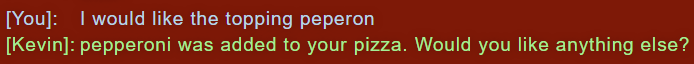

Unfortunately, a balance must be struck between how lenient the model is towards spelling mistakes, and how easily it confuses one known entity with a different but similarly spelt entity. There is therefore a limit to how much an entity, expressed in the user input, can vary from its 'original' spelling, while still being detected.

Consequently, the model is less lenient towards misspellings in cases where it finds the token to be similar in spelling to multiple known entities, all of which are also close in spelling to each other.

For example, inputting 'chkn wdgs' (to mean 'chicken wedges'):

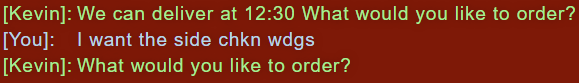

As there are multiple known entities containing 'chicken', as well as multiple known entities containing 'wedges', the model is less flexible towards the given spelling mistake. In this case, the model therefore does not detect the intended entity 'chicken wedges', and therefore repeats its question to the user. 

It must be acknowledged that the spelling in the user input is not likely to vary as much from the actual entity as in the scenario above, however, this does highlight that there is a limit to the chatbot's ability to deal with spelling mistakes.

# Dialogue flow manager

The dialogue flow manager (DFM) is responsible for organizing the infromation used by the chatbot and deciding the action to be performed based off of the user query and current state of this data. The DFM builds and returns a response to the user query about the action performed, if it was valid, etc.

The sayList function helps the DFM format an array into a grammatically correct string.

In [ ]:
# Sentence helper method
# Returns a string that contains all contents of an array in a human readable format
def sayList(arr):
    sentence = ''
    
    if len(arr) >= 2:
      for i in range(len(arr)-2):
        sentence += str(arr[i]) + ', '

      sentence += str(arr[-2]) + ' and '

    if len(arr) >= 1:
      sentence += str(arr[-1])

    return sentence

example_arr = ["Mike", "Sally", "Kevin", "Jamie", "Ralph"]
print("Many words:\t" + sayList(example_arr))

example_arr = ["Mike", "Sally"]
print("Two words:\t" + sayList(example_arr))

example_arr = ["Mike"]
print("One word:\t" + sayList(example_arr))

Many words:	Mike, Sally, Kevin, Jamie and Ralph
Two words:	Mike and Sally
One word:	Mike


In [ ]:
menu = {}
menu["Toppings"] = ['Pepperoni', 'Chicken_Strips', 'Sweetcorn', 'Ham', 'Mushrooms', 'Onions', 'Pineapple', 'Smoked Bacon Rashers', 
                    'Green and Red Peppers', 'Jalapeno Peppers', 'Tandoori Chicken', 'Pork Meatballs', 'Olives', 'Ground Beef', 
                    'Sausage', 'Garlic spread', 'Chorizo Sausage', 'Tomatoes', 'Tuna', 'Sliced Gherkins']
menu["Sides"] = ['Chicken Wedges', 'Garlic_Bread', 'Potato Wedges', 'Salad Bowl', 'Cheesy Garlic Tear and Share', 'Mac n Cheese', 
                 'Cheesy Garlic Bread', 'Cheese Triangles', 'Cheesy Nachos', 'Breaded Chicken Strips', 'BBQ Chicken Wings', 
                 'Beyond Italian Style', 'Sausage Tear & Share', 'Peri-Peri Chicken', 'Wings', 'Loaded Peri-Peri']
menu["Drinks"] = ['Cola Regular Large', 'Orange_Cola', 'Sugar-Free Cola', 'Lemonade', 'Bottled Water']

Stores information about each pizza in the users order

In [ ]:
# The information about a pizza

class Pizza:
  price = 10

  def __init__(self):
    self.toppings = []

  # Add topping to pizza, returns if successful
  # topping -> string
  def addTopping(self, topping):
    if topping.title() in menu["Toppings"]:    # Check if topping is valid
      self.toppings.append(topping)
      return True

    return False

  # Remove topping from pizza, returns if successful
  # topping -> string
  def removeTopping(self, topping):
    if topping in self.toppings:          # Check if topping is on this pizza
      self.toppings.remove(topping)
      return True

    return False

  # Format info as string
  def toString(self):
    sentence = '['

    for i in self.toppings:
      sentence += i + ', '

    sentence = sentence[:-2] + ']'

  # Return sentence listing all toppings
  def getToppings(self):
    return self.toppings

Stores information about the current user the bot is in communication with

In [ ]:
# The information needed by the chatbot to successfully organise a pizza delivery

# The information needed by the chatbot to successfully organise a pizza delivery

class User:
  
  validSides = []

  def __init__(self):
    self.name = None
    self.address = None
    self.deliveryTime = None
    self.pizzas = []
    self.sides = []
    self.drinks = []

    self.editingPizza = None    #The pizza currently being edited

  # Add a pizza to the list
  def newPizza(self):
    newPizza = Pizza()
    self.pizzas.append(newPizza)
    return self.pizzas.index(newPizza)

  # Remove pizza at index
  def removePizza(self, index):
    index -= 1

    if index == self.editingPizza:
      self.editingPizza = 0

    if index < len(self.pizzas) and index >= 0:
      del self.pizzas[index]
      return True

    return False

  # Set the pizza being edited by its index
  def setEditPizza(self, index):
    index -= 1
    
    if index < len(self.pizzas) and index >= 0: # If valid index
      self.editingPizza = index
      return True
    return False

  # Get the currently edited pizza
  def getEditPizza(self):
    return self.pizzas[self.editingPizza]

  def addSide(self, side):
    print(side.title())
    if side.title() in menu["Sides"]:    # Check if side is valid
      self.sides.append(side)
      return True
    return False

  def removeSide(self, side):
    if side in self.sides:          # Check if side is on this order
      self.sides.remove(side)
      return True
    return False

  def addDrink(self, drink):
    if drink.title() in menu["Drinks"]:    # Check if drink is valid
      self.drinks.append(drink)
      return True
    return False

  def removeDrink(self, drink):
    if drink in self.drinks:          # Check if drink is on this order
      self.drinks.remove(drink)
      return True
    return False

  # Return sentence listing all sides
  def getSides(self):
    return self.sides

  # Return sentence listing all drinks
  def getDrinks(self):
    return self.drinks

  def toString(self):
    names = ["Name", "Address", "Pizzas", "Sides", "Drinks"]
    arr = [self.name, self.address, [sayList(i.getToppings()) for i in self.pizzas], self.sides, self.drinks]
    sentence = ''

    for i, j in zip(names, arr):
      sentence += (i + ": ").ljust(10) + str(j) + '\n'

    return sentence[:-1]

The main DFM structure. The below function can be called using the parameters: user, entities, and intent which are information about the current user, entities extracted by the NER, and output of the intent classifier respectively. <br>

The structure of the DFM uses simple heuristics as opposed to an ML model. We chose this design because it is the most accurate and efficient and is often more predictable than using an ML model. If while testing an incorrect behaviour occurs, then it is much easier to change the heuristics to correct this. With an ML model it would have to be retrained and new data would need to be gathered.

In [ ]:
# The main dialogue flow manager
# user the user object holding all information about the user
# query is the sentence that the user intput into the bot
# intent is the classified intent of the user input
def DFM(user, entities, intent):
    try:
        # The response to the user
        response = ''
        
        if intent == -1:
            response = "I don't understand, could you repeat that?"

        # Greeting
        elif intent == 0:
            response = 'Hello, nice to meet you. How can I help you?'

        # Name
        elif intent == 1:
            user.name = entities[0][0]
            response = 'Nice to meet you ' + ' '.join(entities[0][0])

        # Address
        elif intent == 2:
            user.address = entities[0][0]
            response = 'We can deliver to ' + ' '.join(entities[0][0])

        # DeliveryTime
        elif intent == 3:
            user.deliveryTime = entities[0][0]
            response = 'We can deliver at ' + entities[0][0]

        # NumberOfPizzas
        elif intent == 4:
            for x in range(entities[0][0]):
                pizzaIndex = user.newPizza()
                user.setEditPizza(pizzaIndex + 1)
            response = 'There are now {} pizzas on your order, what would you like on it?'.format(pizzaIndex + 1) 
            

        # AddPizza
        elif intent == 5:
            pizzaIndex = user.newPizza()
            user.setEditPizza(pizzaIndex + 1)
            response = 'This will be pizza {} on your order, what would you like on it?'.format(pizzaIndex + 1)

        # RemovePizza
        elif intent == 6:
            if user.removePizza(int(entities[0][0])):
                response = 'We have removed pizza {} from your order'.format(entities[0][0])
            else:
                response = 'Sorry there are only {} pizzas on your order'.format(len(user.pizzas))

        # EditPizza
        elif intent == 7:
            if user.setEditPizza(int(entities[0][0])):
                pizza = user.getEditPizza()
                response = 'Pizza {} has {} toppings on it, what would you like to change?'.format(entities[0][0], sayList(pizza.getToppings()))
            else:
                response = 'Sorry there are only {} pizzas on your order'.format(len(user.pizzas))

        # AddTopping
        elif intent == 8:
            pizza = user.getEditPizza()

            # Seperate toppings if they are valid or not
            valid = [[],[]]  # index 0: not valid topping, index 1: valid topping
            for t in entities:
                index = pizza.addTopping(t[0])
                valid[index].append(t[0])

            if len(valid[1]):
                response += sayList(valid[1]) + ' was added to your pizza. '
            if len(valid[0]):
                response += 'Sorry we do not have {} in our shop'.format(sayList(valid[1]))

        # RemoveTopping
        elif intent == 9:
            pizza = user.getEditPizza()

            # Seperate toppings if they are valid or not
            valid = [[],[]]  # index 0: not valid topping, index 1: valid topping
            for t in entities:
                index = pizza.removeTopping(t[0])
                valid[index].append(t[0])

            if len(valid[1]):
                response = 'We have removed {} from your pizza, now it only has the toppings {}. '.format(sayList(valid[1]), sayList(pizza.getToppings()))
            if len(valid[0]):
                response = 'Sorry {} is not on that pizza'.format(sayList(valid[0]))

        # AddSide
        elif intent == 10:
            # Seperate toppings if they are valid or not
            valid = [[],[]]  # index 0: not valid topping, index 1: valid topping
            for t in entities:
                index = user.addSide(t[0])
                valid[index].append(t[0])

            if len(valid[1]):
                response += 'Your order now has the sides ' + sayList(valid[1])
            if len(valid[0]):
                response += 'Sorry we do not have {} in our shop'.format(sayList(valid[0]))

        # RemoveSide
        elif intent == 11:
            # Seperate toppings if they are valid or not
            valid = [[],[]]  # index 0: not valid topping, index 1: valid topping
            for t in entities:
                index = user.removeSide(t[0])
                valid[index].append(t[0])

            if len(valid[1]):
                if len(user.sides) == 0:
                    response = '{} was removed, you order now contains no sides'.format(sayList(valid[1]))
                else:
                    response = '{} was removed, now your order has the sides {}'.format(sayList(valid[1]), sayList(user.getSides()))
                
            if len(valid[0]):
                response = 'Sorry {} is not on this order'.format(sayList(valid[0]))

        # AddDrink
        elif intent == 12:
            # Seperate toppings if they are valid or not
            valid = [[],[]]  # index 0: not valid topping, index 1: valid topping
            for t in entities:
                index = user.addDrink(t[0])
                valid[index].append(t[0])

            if len(valid[1]):
                response += 'Your order now has the drinks: ' + sayList(valid[1])
            if len(valid[0]):
                response += 'Sorry we do not have {} in our shop'.format(sayList(valid[0]))
        
        # RemoveDrink
        elif intent == 13:
            # Seperate toppings if they are valid or not
            valid = [[],[]]  # index 0: not valid topping, index 1: valid topping
            for t in entities:
                index = user.removeDrink(t[0])
                valid[index].append(t[0])

            if len(valid[1]):
                if len(user.drinks) == 0:
                    response = '{} was removed, you order now contains no drinks'.format(sayList(valid[1]))
                else:
                    response = '{} was removed, now your order has the drinks {}'.format(sayList(valid[0]), sayList(user.getDrinks()))
            
            if len(valid[0]):
                response = 'Sorry {} is not on this order'.format(sayList(valid[0]))

        # EndConv (end of conversation)
        elif intent == 14:
            pizzas = (sayList(["pizza {} with ".format(str(i+1)) + sayList(j.getToppings()) for i,j in enumerate(user.pizzas)]) + ", ") if len(user.pizzas) > 0 else ''
            sidesAndDrinks = ("with additional sides and drinks " + sayList([sayList(user.sides), sayList(user.drinks)]) + ", ") if len(user.sides)+len(user.drinks) > 0 else ''

            response = 'Your order of {} pizzas, {}{}will be dispatched soon! Goodbye'.format(len(user.pizzas), pizzas, sidesAndDrinks)
    except IndexError:
        response = "I don't understand, could you repeat that?"
    finally:
        return response

# Chatbot

## Deploying the web application
There are a wide variety of ways we could serve the model, they are explained 

Flask is a python web application framework which can easy create an application which serves the models. It is easy to use. (see reference 1 and see reference 2). Fast API is a fast web application frame work which is also easy to use. (see reference 3).  Other potential options are BentoML, TorchServe, ForestFlow, and Seldon Core. (see reference 4)

We have decided to use Flask because it is the easiest option to use, and it is effective enough for an application with a small number of ML models and data like out one.  Flask was chosen instead of Fast API because it is easier to use Flask for rendering web pages.



In [ ]:
!pip install flask-ngrok
!pip install flask-bootstrap
!pip install flask==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 456 kB 7.8 MB/s 
  Created wheel for flask-bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=1a7fcf2ab579077bbd84df73c0d650fb8a5263686e9c60d1d2c46518d72dc9b2
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for visitor: filename=visitor-0.1.3-py3-none-any.whl size=3946 sha256=6fd148fa27ce192268f062e93978cc04cd685afd22482a867b47a36721ac054a
  Stored in directory: /root/.cache/pip/wheels/64/34/11/053f47218984c9a31a00f911ed98dda036b867481dcc527a12
Successfully built flask-bootstrap visitor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.6 MB/s 
  Attemptin

In [ ]:
!pip install pyngrok
!ngrok authtoken 29Yxs3Ou60LESoRkBikVcT4aowo_4BBBrTYuJDgWeQtQA8mYU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 8.1 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=5dcd78ab3a0ea3df660e674505bcc2547ad8fd7b6d0304a526438db70030b27f
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


To start the application, the below cell must be run.

When the application is started, the user will be on the home.html page, which contains a start button. When the user presses the start button, the chatbot is initiated, User object is created, and the user will be on the index.html page which lets the user input a query.

The user can then input a query into the form and submit the query. The intent of the query and the entites which the query contains is determined and the dialogue flow manager is used to determine the output of the chatbot. As mentioned in the intent classifier section, the NER is first used on the query and then specific instances of an entity with its class are replaced.

The application will check the following conditions:

*   The user has specified the name
*   The user has specified the address

*   The user has specified the delivery time
*   The user has ordered anything

If all of the above conditions are satisfied, the application will let the user complete the request, and the results.html page will be used to output the conversation.  If any of the above conditions are not satisfied, the application will not let the user complete the request. The results.html page was used to output the conversation so that the user cannot submit queries after the request is completed.

In [ ]:
from flask import Flask, request, jsonify, render_template
from flask_ngrok import run_with_ngrok
import time

app = Flask(__name__, template_folder='drive/MyDrive/COM3029_coursework_2/Main/Website/templates', static_folder='drive/MyDrive/COM3029_coursework_2/Main/Website/static')
run_with_ngrok(app)

savedChat = []
user = None

@app.route('/')
def home():
    return render_template('home.html')

@app.route('/predict',methods=['POST'])
def predict():
    start = time.time()
    global user
    if not user:
        user = User()
        input_query = [None]
        output = "Hi, I am Pizza Kevin. What is your name?"
    else:
        input_query = [str(x) for x in request.form.values()]
        query = input_query[0]
        entities = get_entities(query)
        for entity in entities:
            query = query.replace(entity[0],ent_classes[entity[1]])
        intent = get_intent(query)
        output = DFM(user,entities,intent)
        if user.name == None:
            if intent == 14:
                output = "You can't leave yet, I still need your name."
            else:
                output += " What is your name?"
        elif user.address == None:
            if intent == 14:
                output = "You can't leave yet, I still need your address."
            else:
                output += " What is your address?"
        elif user.deliveryTime == None:
            if intent == 14:
                output = "You can't leave yet, I still need to know what time you want your order."
            else:
                output += " What time do you want your order?"
        elif not (len(user.pizzas) or len(user.sides) or len(user.drinks)):
            if intent == 14:
                output = "You can't leave yet, you still have nothing in your order."
            else:
                output += " What would you like to order?"
        else:
            if intent == 14:
                savedChat.append((input_query[0], output))
                with open('log_file_chatbot.log', 'a+') as f:
                    f.write('[You]: ' + input_query[0] + '\n')
                    f.write('[Kevin]: ' + output + '\n')
                    f.write('\n')
                end = time.time()
                print("Time taken: " + str(end - start) + "seconds")
                return render_template('result.html', myChat=savedChat)
            else:
                output += " Would you like anything else?"
    savedChat.append((input_query[0], output))
    with open('log_file_chatbot.log', 'a+') as f:
        if input_query[0] != None:
            f.write('[You]: ' + input_query[0] + '\n')
        f.write('[Kevin]: ' + output + '\n')
    print(savedChat)

    end = time.time()
    print("Time taken: " + str(end - start) + "seconds")
    return render_template('index.html', myChat=savedChat)

if __name__ == "__main__":
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://93d4-34-82-228-66.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [25/May/2022 14:19:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/May/2022 14:19:11] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [25/May/2022 14:19:11] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [25/May/2022 14:19:12] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?')]
Time taken: 0.0015413761138916016seconds


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  uninitialized_encoder_weights += list(all_encoder_weights)
127.0.0.1 - - [25/May/2022 14:19:20] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?')]
Time taken: 3.8414952754974365seconds


127.0.0.1 - - [25/May/2022 14:19:29] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?')]
Time taken: 1.6362533569335938seconds


127.0.0.1 - - [25/May/2022 14:19:36] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?')]
Time taken: 1.641706943511963seconds


127.0.0.1 - - [25/May/2022 14:19:43] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?')]
Time taken: 1.6252994537353516seconds


127.0.0.1 - - [25/May/2022 14:19:45] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?')]
Time taken: 1.656031608581543seconds


127.0.0.1 - - [25/May/2022 14:20:05] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('pizza', 'This will be pizza 1 on your order, what would you like on it? Would you like anything else?')]
Time taken: 1.7437138557434082seconds


127.0.0.1 - - [25/May/2022 14:20:19] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('pizza', 'This will be pizza 1 on your order, what would you like on it? Would you like anything else?'), ('ham and pepperoni', 'ham and pepperoni was added to your pizza.  Would you like anything else?')]
Time taken: 1.673187255859375seconds


127.0.0.1 - - [25/May/2022 14:20:27] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('pizza', 'This will be pizza 1 on your order, what would you like on it? Would you like anything else?'), ('ham and pepperoni', 'ham and pepperoni was added to your pizza.  Would you like anything else?'), ('add another pizza', 'This will be pizza 2 on your order, what would you like on it? Would you like anything else?')]
Time taken: 1.6403210163116455seconds


127.0.0.1 - - [25/May/2022 14:20:39] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('pizza', 'This will be pizza 1 on your order, what would you like on it? Would you like anything else?'), ('ham and pepperoni', 'ham and pepperoni was added to your pizza.  Would you like anything else?'), ('add another pizza', 'This will be pizza 2 on your order, what would you like on it? Would you like anything else?'), ('add lemonade', 'Your order now has the drinks: lemonade Would you like anything else?')]
Time taken: 1.6103615760803223seconds


127.0.0.1 - - [25/May/2022 14:20:56] "POST /predict HTTP/1.1" 200 -


Wings
Cheese Triangles
[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('pizza', 'This will be pizza 1 on your order, what would you like on it? Would you like anything else?'), ('ham and pepperoni', 'ham and pepperoni was added to your pizza.  Would you like anything else?'), ('add another pizza', 'This will be pizza 2 on your order, what would you like on it? Would you like anything else?'), ('add lemonade', 'Your order now has the drinks: lemonade Would you like anything else?'), ('add cheesy triangles and wings', 'Your order now has the sides wings and cheese triangles Would you like anything else?')]
Time taken: 1.642964839

127.0.0.1 - - [25/May/2022 14:21:07] "POST /predict HTTP/1.1" 200 -


[(None, 'Hi, I am Pizza Kevin. What is your name?'), ('hello', 'Hello, nice to meet you. How can I help you? What is your name?'), ('Penny', 'Nice to meet you P e n n y What is your address?'), ('gu2 7jh', 'We can deliver to g u 2   7 j h What time do you want your order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('12:30', 'We can deliver at 12:30 What would you like to order?'), ('pizza', 'This will be pizza 1 on your order, what would you like on it? Would you like anything else?'), ('ham and pepperoni', 'ham and pepperoni was added to your pizza.  Would you like anything else?'), ('add another pizza', 'This will be pizza 2 on your order, what would you like on it? Would you like anything else?'), ('add lemonade', 'Your order now has the drinks: lemonade Would you like anything else?'), ('add cheesy triangles and wings', 'Your order now has the sides wings and cheese triangles Would you like anything else?'), ('remove lemonade', 'lemonade was removed, you

127.0.0.1 - - [25/May/2022 14:21:16] "POST /predict HTTP/1.1" 200 -


## Testing the chatbot

### initiate the chatbot
The following screenshots show the chatbot being initiated:


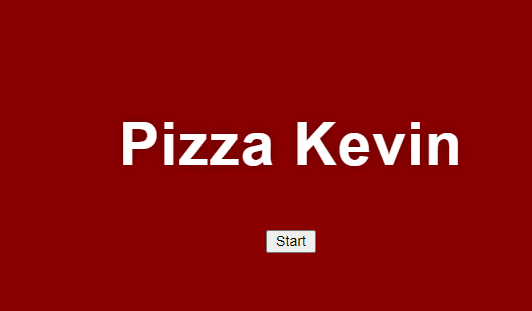

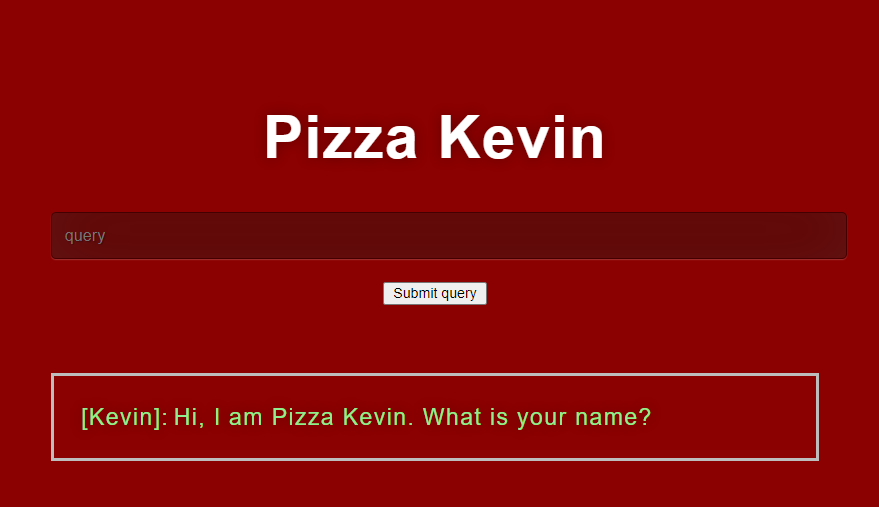



### Confusing the chatbot
The following screenshots show the user trying to confuse the chatbot by specifying the address instead of the name:

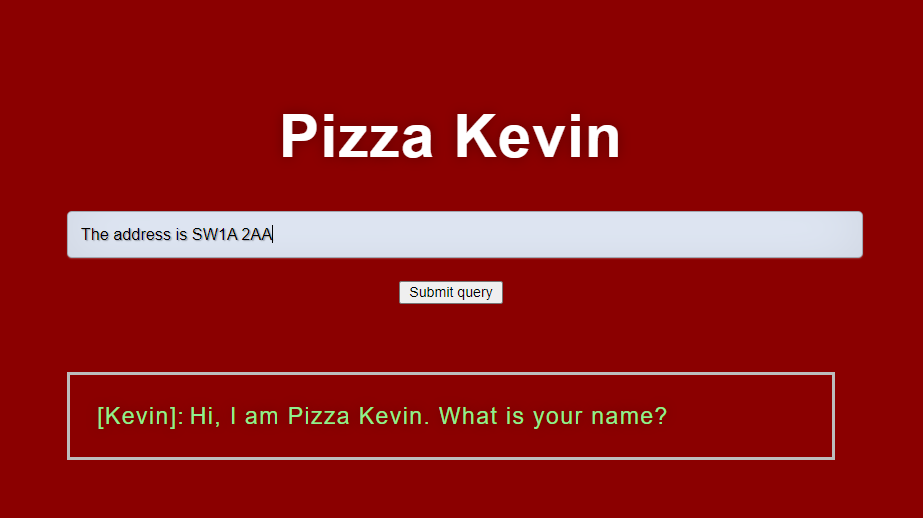

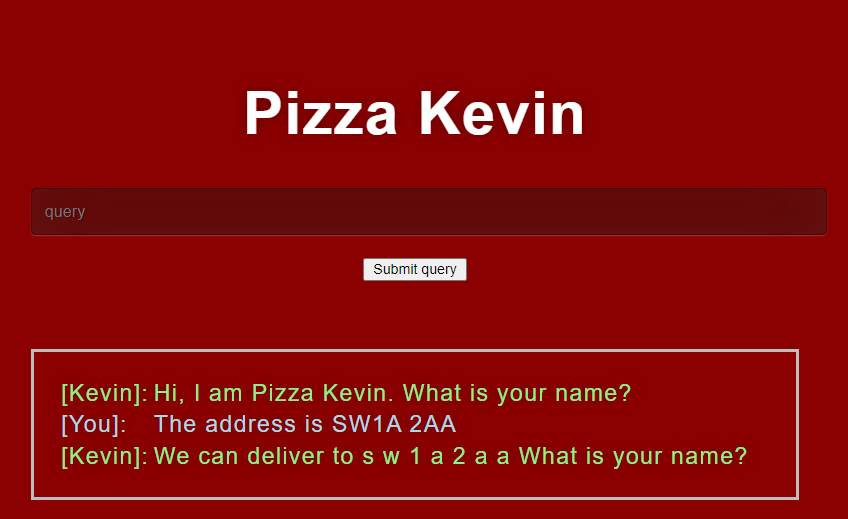

As shown by the screenshots, the chatbot will acknowledge the address, however it will still ask for the name.

### override a previous entry
The following screenshots show the user overriding the name entry:

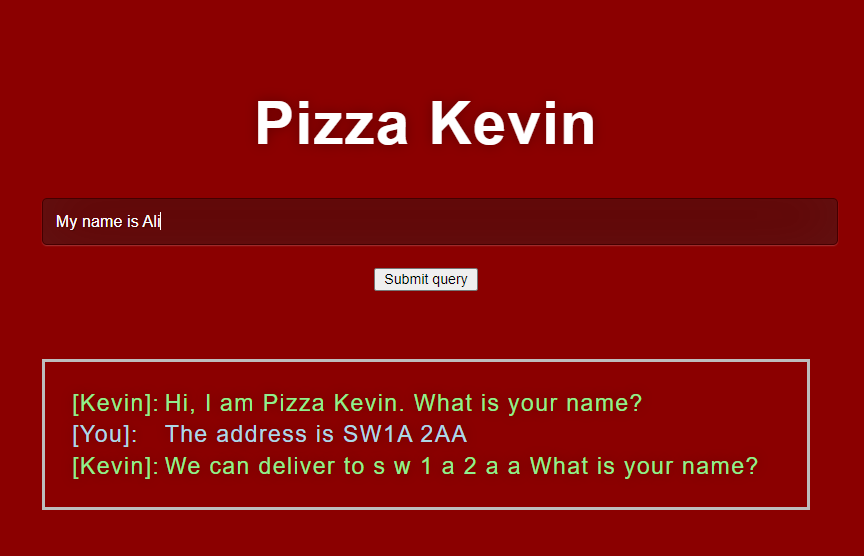

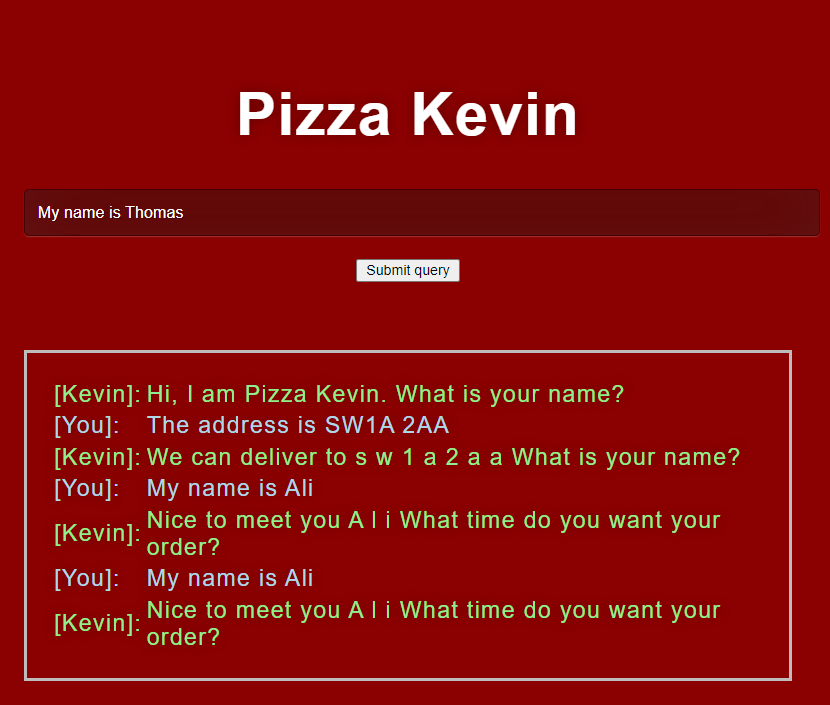

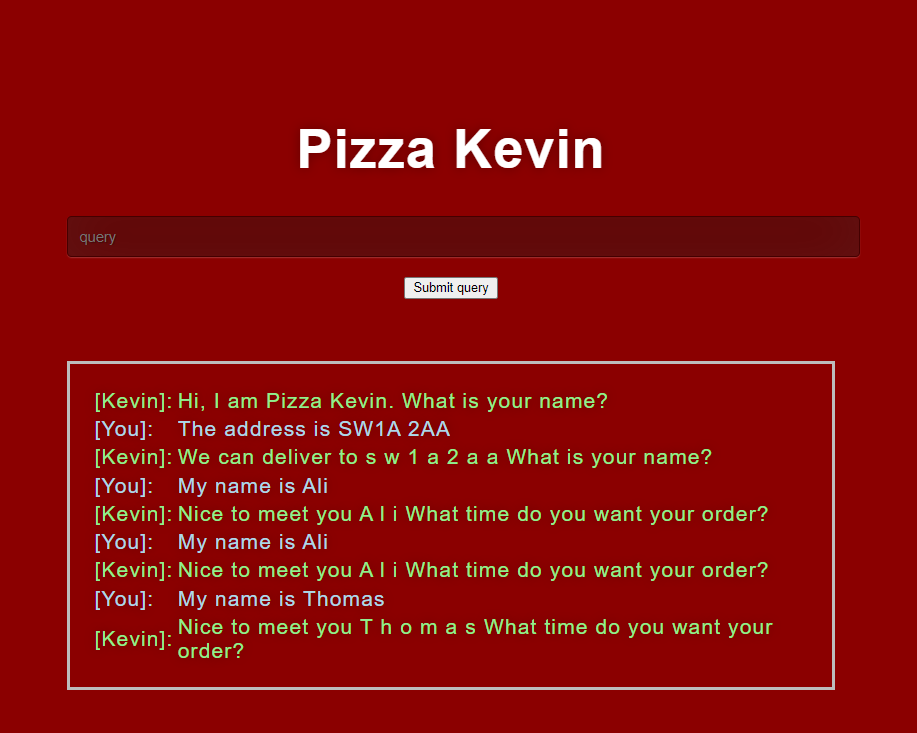

### Complete a request:
The following screenshots show the user completing a request:

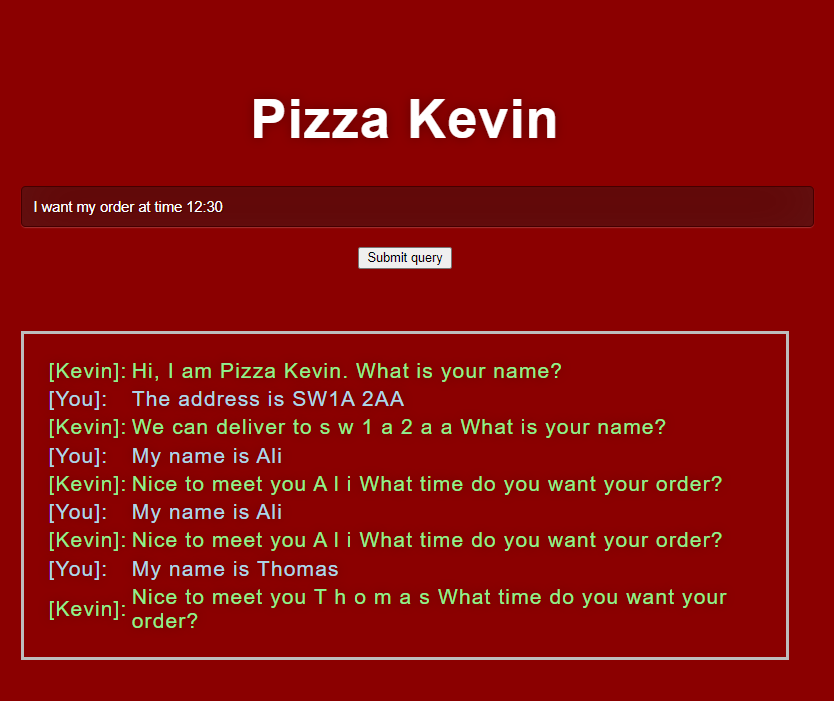

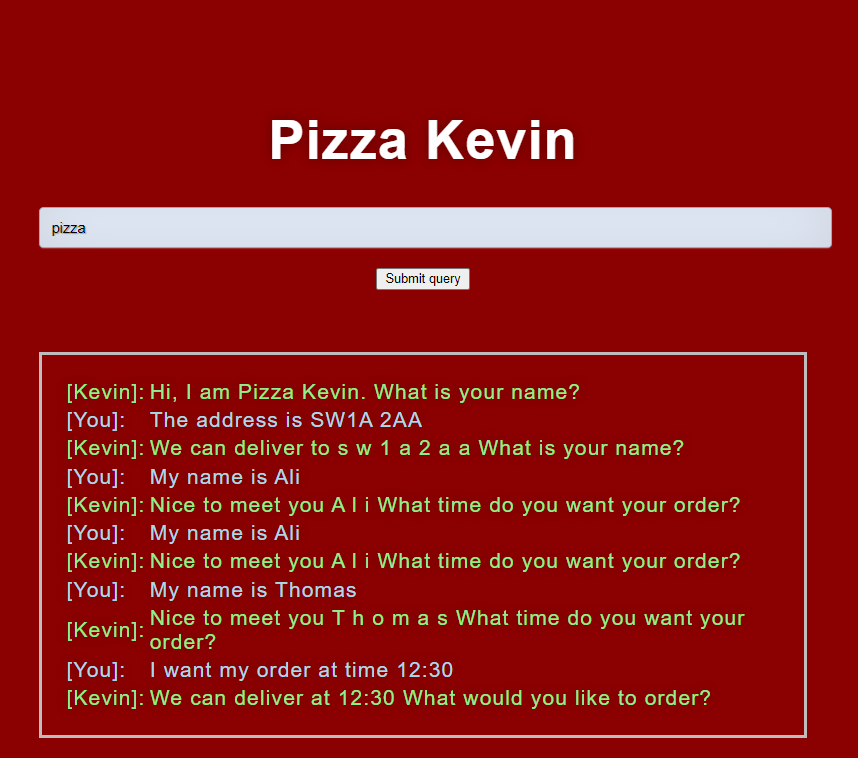

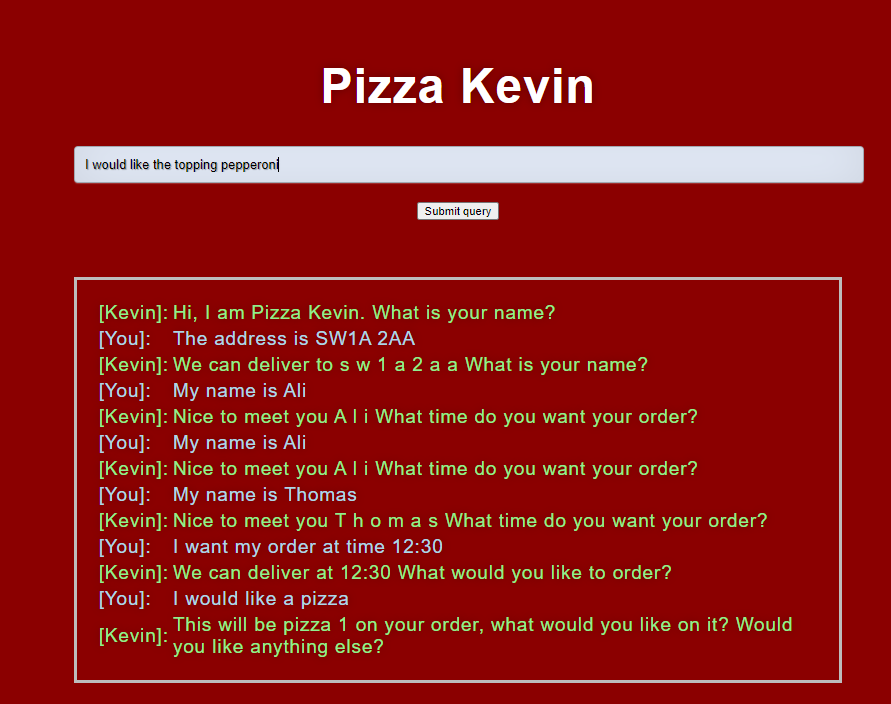

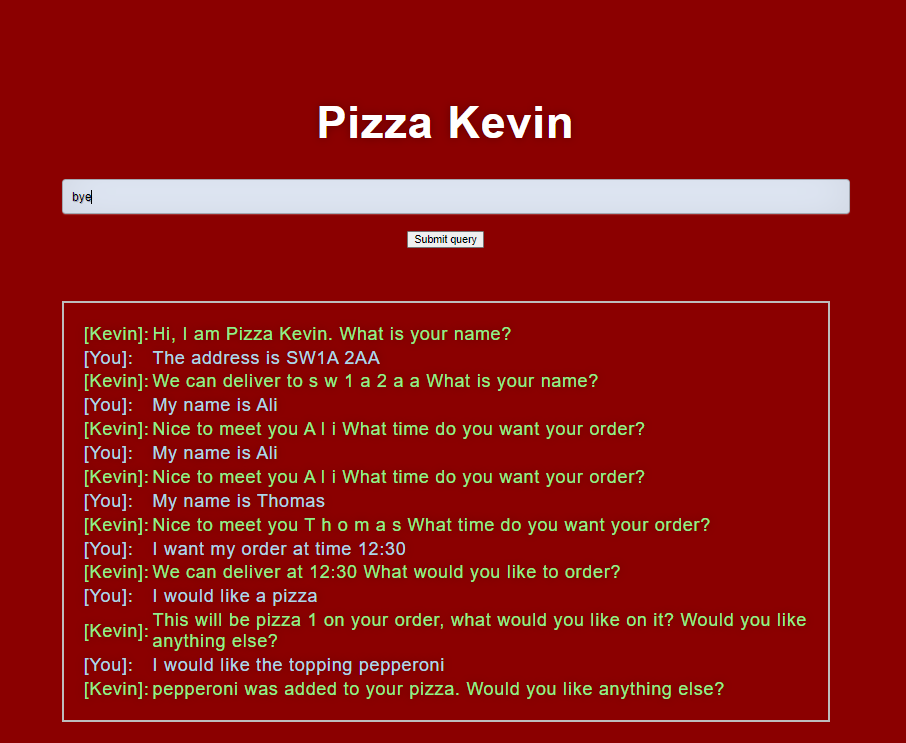

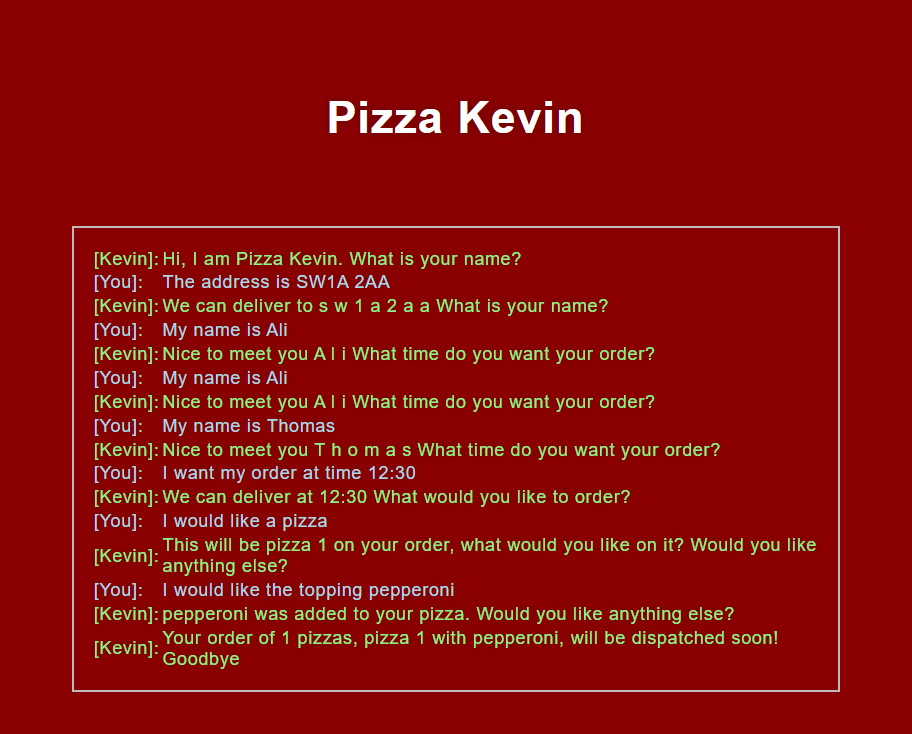

## Stretch Testing by Class

An interesting aspect to discuss is how can we ensure the intent classifier knows specific entities are of a certain class, e.g. knowing 12:30 refers to the delivery time class? This is accomplished by first using the NER on the query and then replacing specific instances of an entity with its class, e.g. replacing "12:30" in the user input with "time". 

The dataset for the intent classifier has been updated to ensure that its training data includes examples such as "time" for class 3 (delivery time), and "post code" for class 2 (address). 

With the NER-powered replacement, the intent classifier can correctly understand that a specific postcode refers to the Address class, making the chatbot conversation flow more natural and gives the illusion of it being able to remember context.

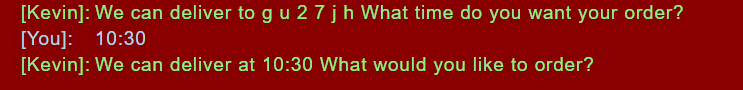

As you can see from above, Pizza Kevin (our chatbot) correctly classed the input of "gu2 7jh" as referring to the address class without even having to explicitly state it is the address. So too with 10:30.

However, there are still some problems. Pizza kevin recognizes any entities that are uppercase as a name. 

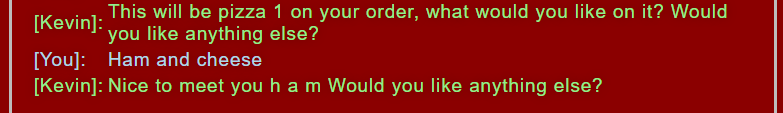

It works when you use all lower case.

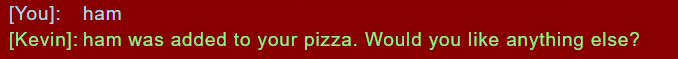

### Class 0 - Greeting

The best thing about using pretrained BERT is that it makes it very flexible in terms of stretch testing, for example, let's try "bonjour" as a greeting as this was not in the original dataset.

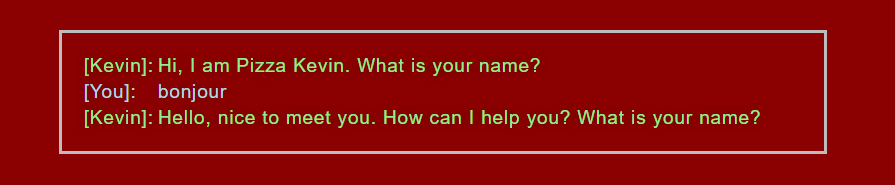

It even works for niche slang such as "wagwan"

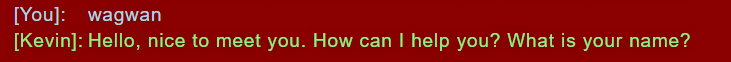

### Class 1 - Name

Similarly, the chatbot is intelligent enough to pick out a name.

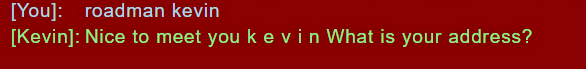

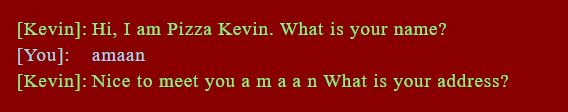

For stranger names, the chatbot doesn't realise it's a name unless it's capitalised.

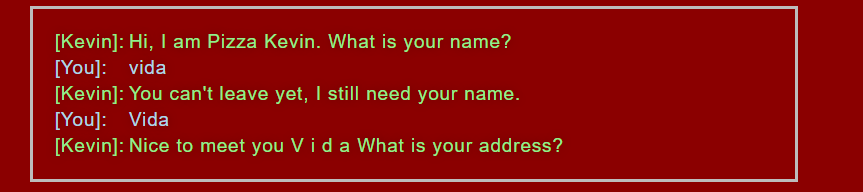

### Class 2 - Address

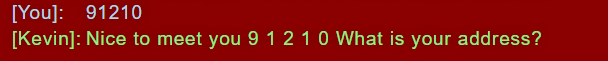

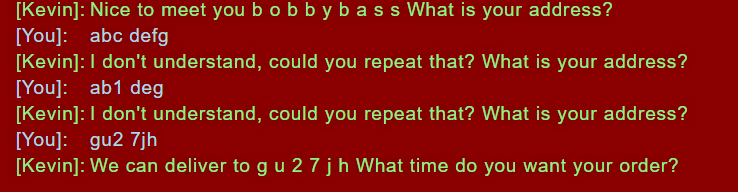

### Class 3 - DeliveryTime

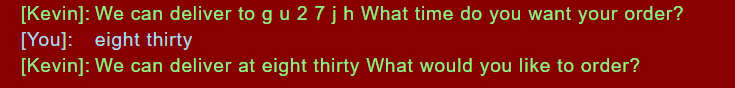

"tomorrow" crashes the chatbot, as does "this evening"

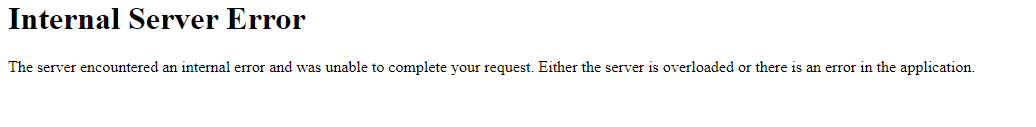

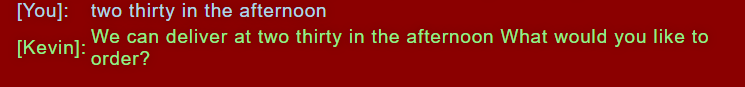

### Class 4 - NumberOfPizzas

We found that this class was quite superfluous and that the intent classifier gets confused about what this means. As it doesn't know if "5 pizzas" means adding 5 pizzas or refers to 5 pizzas.

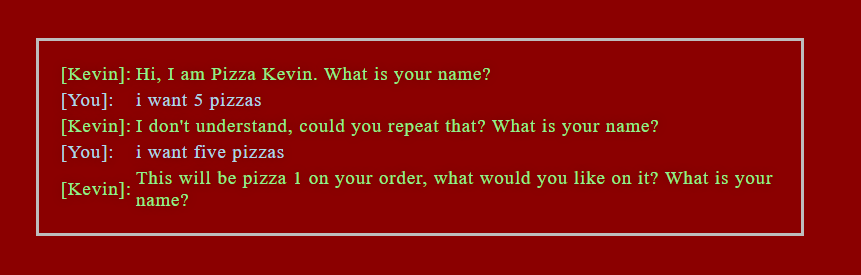

### Class 5 - AddPizza

This class is unfortunately inflexible in terms of how it identifies what a pizza is. The chatbot does understand "pizza" means adding a pizza to your order, but it doesn't understand complex synonyms for pizza.

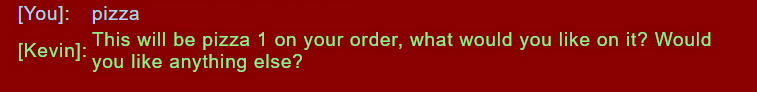

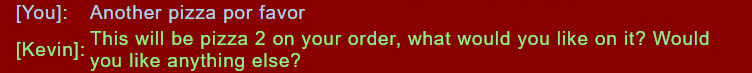

It doesn't know that we are referring to pizza below:

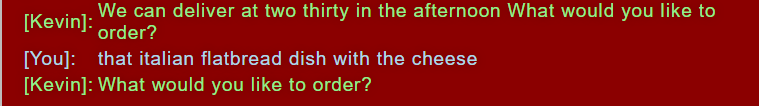

For the menu, in the future, it would be useful to alert the user of the possible toppings, sides, and dishes they can choose. Such as adding a "DisplayMenu" intent.

### Class 6 - Remove pizza

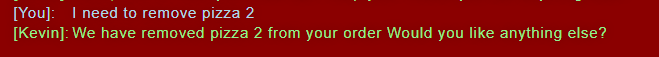

### Class 7 - EditPizza

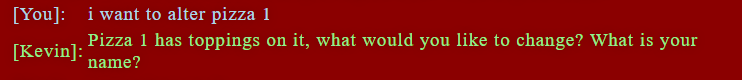

### Class 8 - AddTopping

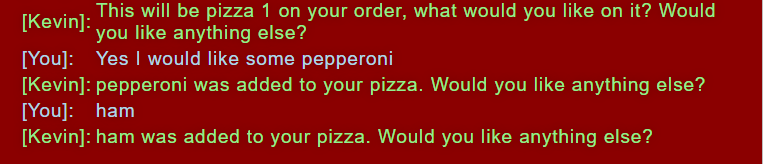

If you do not have a pizza, you cannot add any toppings. It just ignores you.

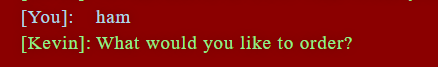

### Class 10 - AddSide

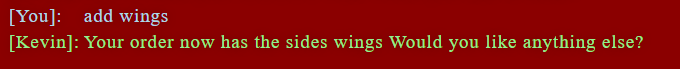

the chatbot doesn't understand if you put a "silly" input like "my dear kevin"

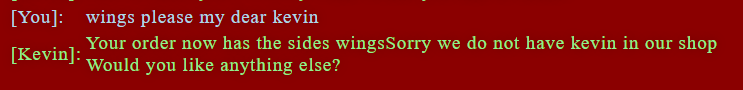

You can add several sides at the same time thanks to the NER

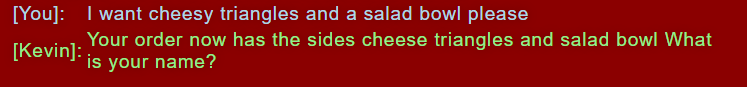

### Class 11 - RemoveSide

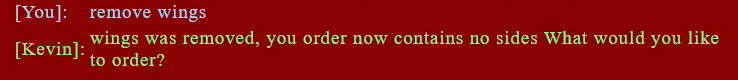

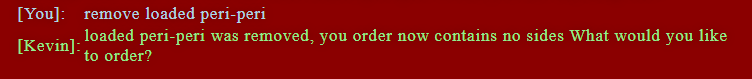

Unfortunately, if you only have one side and simply want to remove it, the chatbot doesn't realise there's only one side to refer to and ignores your request of removal of the unspecified side "remove side"

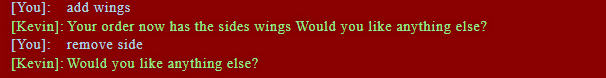

You can ask for several sides to be removed at the same time

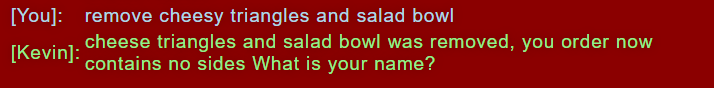

### Class 12 - AddDrink

a limitation of our chatbot is that it doesn't understand synonyms for the same drinks. Our menu includes "sugar-free cola" but the chatbot doesn't recognize "coke zero" or "diet coke" 

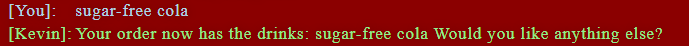

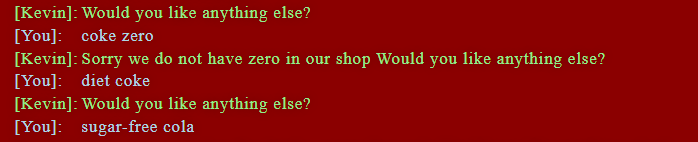

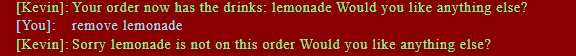

Similar to sides and toppings you can add several drinks at a time

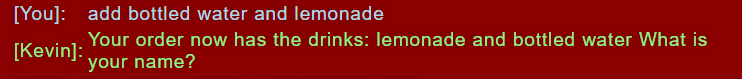

The chatbot struggles with some items, such as cola regular large

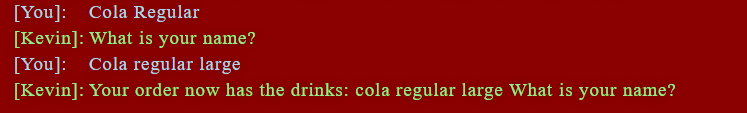

### Class 13 - Remove drink

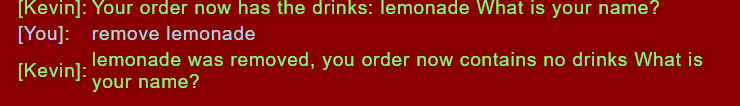

You can also remove several drinks at a time

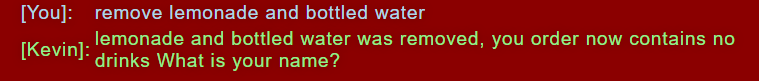

### Class 14 -  EndConv

The chatbot struggles with some salutations. Such as "Seeya!"

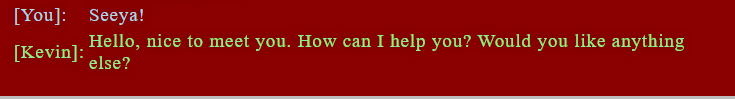

Luckily the chatbot understands "Goodbye Kevin" is ending the conversation instead of specifying the name.

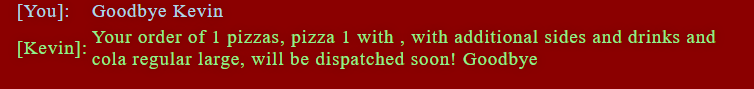

### Class -1 - Unknown

The chatbot has also been trained on some 'random' items for the unknown intent, so if you give the chatbot rubbish it correctly does not understand.

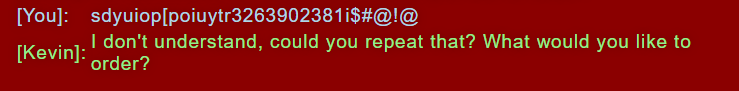

It is better for the chatbot to not understand an intent and consider it unknown than to incorrectly classify an intent into the wrong class. Incorrect classification is unlikely to occur compared to it being unknown due to the NER having to identify an entity in the intent; if it doesn't identify one when it's been put in the wrong class, you automatically just get unknown.

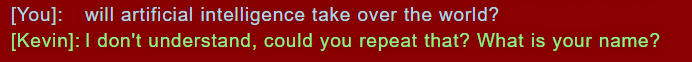

Perhaps Kevin is playing dumb for us...

### Removal Error

The error was because the removal checks for the capitalized version of the item in the menu, but the addition did not. We removed the capitalization and now removing toppings, sides, and drinks works as expected. Pizza removal was already working.

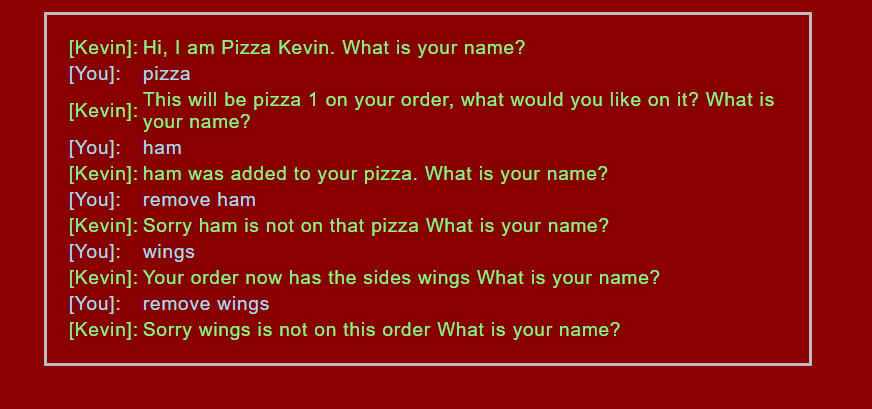

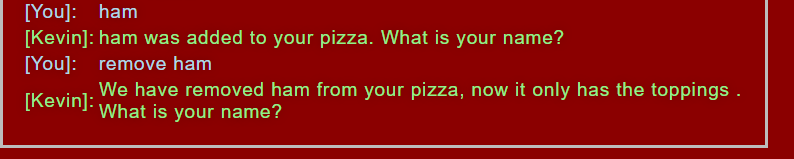

### Fixing the chatbot crash

it seems very easy to crash the bot.

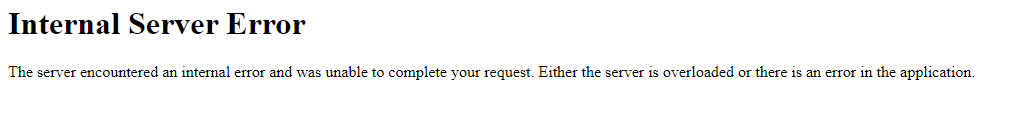

asking "what is your name?" crashes

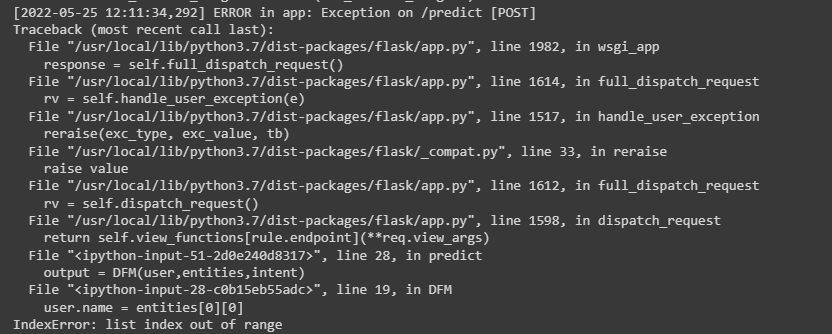

"au revoir" crashes the bot. so too does "we'll meet again. don't know where, don't know when".

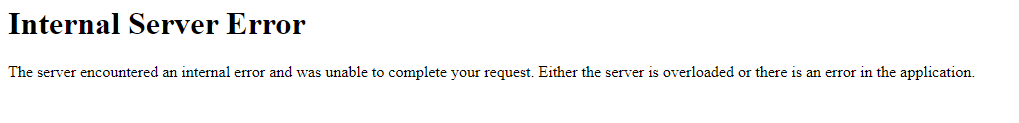

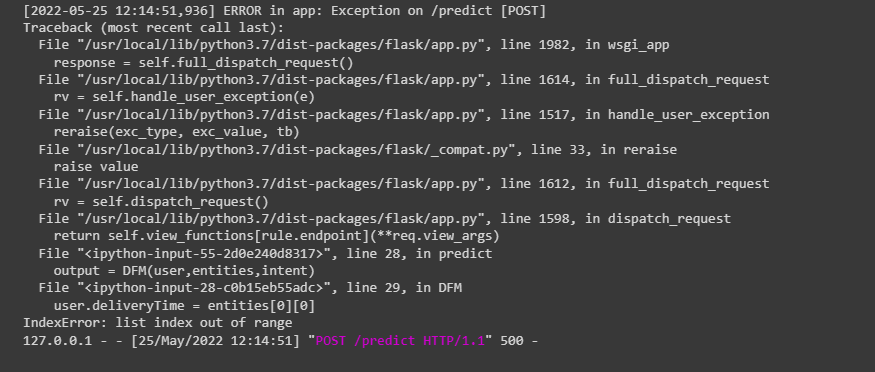

This crashes because the sentence is classed as an intent with entities attached, such as "delivery time", but the NER cannot identify any entities, so when it comes to trying to assign the delivery time it leads to an exception as it's a 0 length list of entities and therefore out of range.

We fixed this by checking the length of the entities list returned from get_entities(), if it's length 0, we redirect the outputted intent to the "Unknown" class, or -1. 

We fixed the chatbot to no longer crash, but to simply say it doesn't understand.

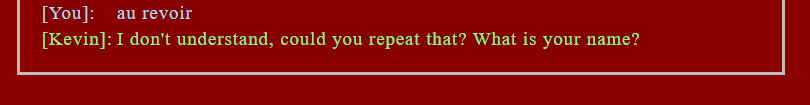

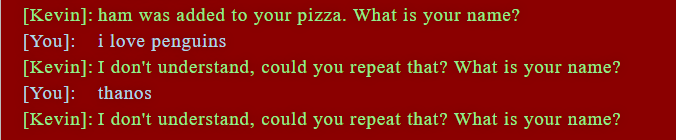

### Out of order intents - 

You can successfully discuss intents out of order, such as supplying the time before the address.

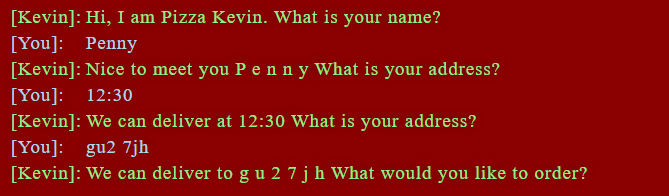

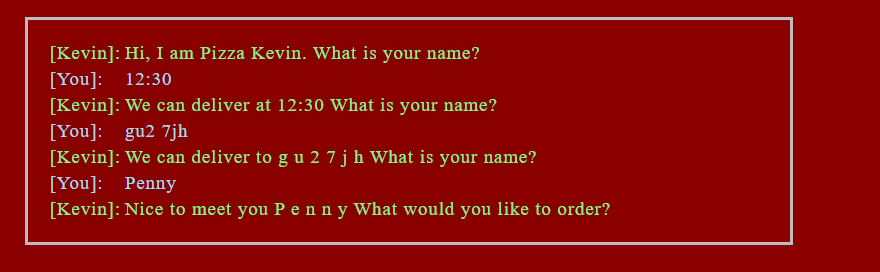

## Overall comments on chatbot performance

The chatbot takes 1 to 2 seconds to calculate the next response. This is not noticeable with only 1 user, however it will become exponentially slower with more concurrent users as the chatbot does not execute in parallel, meaning that scalability is huge issue. In the future we will have to measure the performance of each individual component of the chatbot to understand which is the slowest and therefore where the greatest performance increases can be found. Perhaps we could also decrease the number of calls to other functions and the number of nested for loops and other O(N^2) components used in the predict() function to optimise our chatbot.

In terms of the size of the request, we have not tested the time it calculates different length inputs. As our chatbot is not multi-label it's unlikely that a user input will be longer than a sentence as they can only specify one aspect of the order at a time (i.e. you can't say your postcode and the toppings of the pizza in the same input). Therefore each input is unlikely to be far longer than the shortest inputs and therefore won't affect the processing time too greatly, however further testing must be done to prove this.

For the size of the models, we could certainly save some processing time by downscaling the intent classifier from using a pretrained BERT to using a simple CNN. However, this would be at the risk of degrading accuracy. As for the dialogue flow manager, no neural network was used however there are many if-else statements and for loops which could be replaced by using Python's version of an switch-statement; a dictionary of strings to functions.

## Basic monitoring capability to capture user inputs and the model predictions

When the application is running, a log file called "log_file_chatbot.log", which stores the user inputs and the chatbot outputs, is created. When a request has been completed, a new line is added to the log file.

## CI/CD pipeline

A notebook called CI-CD.ipynb, which automatically trains the intent classifier and NER, and deploys the models, has been created.

# References


1.   https://towardsdatascience.com/how-to-easily-deploy-machine-learning-models-using-flask-b95af8fe34d4
2.   https://www.digitalocean.com/community/tutorials/how-to-make-a-web-application-using-flask-in-python-3
3.   https://medium.datadriveninvestor.com/flask-on-colab-825d2099d9d8
4.   https://neptune.ai/blog/ml-model-serving-best-tools
5.   https://www.delftstack.com/howto/python/remove-special-characters-from-string-python/
6.   https://digitalfortress.tech/tips/top-15-commonly-used-regex/
7.   https://spacy.io/models
8.   https://regexlib.com/REDetails.aspx?regexp_id=38
9.   https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-most-common-name-dataset?select=new-top-firstNames.csv
10.  https://www.kaggle.com/datasets/manshanawaz/uk-postcode-and-geolocation-dataset?select=1a+Dataset+UK+Postcodes+and+Geolocation+CSV




In [30]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('COM3029 coursework 2.ipynb')

--2022-05-25 14:23:52--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-05-25 14:23:52 (20.8 MB/s) - ‘colab_pdf.py’ saved [1864/1864]



ValueError: ignored